In [6]:
library(tidyverse)
library(data.table)
library(magrittr)
library(harmony)
library(singlecellmethods)

In [3]:
normalizeData <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

In [4]:
# X <- Matrix::t(harmony::ctrl.sparse)
X <- Matrix::cbind2(harmony::ctrl.sparse, harmony::stim.sparse)
X %<>% normalizeData()
X_ctrl <- normalizeData(harmony::ctrl.sparse)
X_stim <- normalizeData(harmony::stim.sparse)

In [5]:
system.time({
    .res <- findVariableGenes(X, c(rep("ctrl", ncol(harmony::ctrl.sparse)), rep("stim", ncol(harmony::stim.sparse))))
#     .res <- findVariableGenes(X_ctrl, rep(0, ncol(X_ctrl)))
})

.res %>% head

   user  system elapsed 
  0.910   0.121   1.033 

symbol,group,gene_mean,gene_dispersion
HBB,stim,4.1808181,8.741350
HBB,ctrl,4.0482791,8.721871
IGLL5,stim,0.7199632,7.981911
HBA2,ctrl,2.7746718,7.428170
HBA2,stim,2.8167331,7.379681
HBG1,ctrl,0.4015790,7.132338


# kmeans

In [2]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
library(mvtnorm)
library(tidyverse)

In [4]:
Rcpp::sourceCpp('src/kmeans.cpp')

In [5]:
## colums are observations
soft_kmeans <- function(X, k, max_iter=20, sigma=0.1) {
    message('WARNING: soft_kmeans fxn uses cosine distance only')
    Z <- cosine_normalize_cpp(X, 2)
    Y <- stats::kmeans(t(Z), centers = k, iter.max = 25, nstart = 10)$centers %>% t() ## D x K
    res <- soft_kmeans_cpp(Y, Z, max_iter, sigma)
    return(res)
}

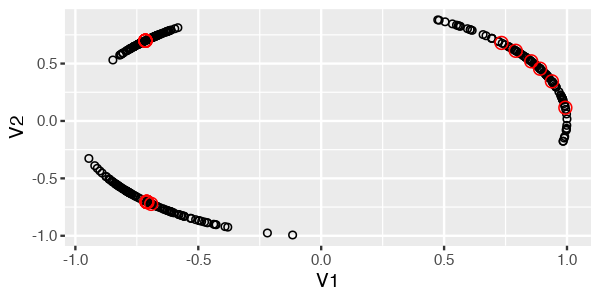

In [6]:
X <- rbind(
    rmvnorm(100, mean = c(1, .5), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, -1), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, 1), sigma = diag(.01, 2))
) %>% 
    cosine_normalize_cpp(1) %>% 
    t()

res <- soft_kmeans(X, 21)
data.table(t(X)) %>% 
    ggplot(aes(V1, V2)) + geom_point(shape = 21) + 
    geom_point(data = data.table(t(res$Y)), color = 'red', shape = 21, size = 3)